# Scalogram test

2025-08-07

- Testing wavelet transforms and scalograms

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

## Functions

In [2]:
def gauss2d(x, y, w):
    return np.exp(-2*(x**2+y**2)/(w**2))

def ricker2d(x, y, a):
    return (1/a**2)*(2-((x/a)**2+(y/a)**2))*np.exp(-(x**2+y**2)/(2*a**2))


def make_kernel(w_kern, f, *func_args, show=True):
    ''' 
    - w_kern: width of the kernel in pixels. kernel centered at (0,0)
    - f, *func_args: the 2d function f(X, Y, *func_args)
    '''
    # To ensure kernel is centered at 0 in both even/odd cases    
    if w_kern % 2: # odd
        offset = 1
    else: # even
        offset = 0.5

    n_arr = np.arange(-w_kern//2, w_kern//2) + offset # ensures centered at 0

    X,Y = np.meshgrid(n_arr, n_arr)
    Z = f(X, Y, *func_args)

    if show:
        fig = plt.figure()
        fig.set(size_inches=fig.get_size_inches()*0.75)
        ax = fig.add_subplot(projection='3d')
        ax.plot_surface(X, Y, Z)
        ax.set_title(f'PSF Convolution kernel')
    
    return Z


def plot_kernel(w_kern, f, *func_args):
    ''' 
    - w_kern: width of the kernel in pixels. kernel centered at (0,0)
    - f, *func_args: the 2d function f(X, Y, *func_args)
    '''
    # To ensure kernel is centered at 0 in both even/odd cases    
    if w_kern % 2: # odd
        offset = 1
    else: # even
        offset = 0.5

    n_arr = np.arange(-w_kern//2, w_kern//2) + offset # ensures centered at 0

    X,Y = np.meshgrid(n_arr, n_arr)
    Z = f(X, Y, *func_args)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X, Y, Z)
    
    return fig, ax


def waveletTransform(im, w_kern, a):
    Z = make_kernel(w_kern, ricker2d, a, show=False)
    WT_arr = sig.convolve2d(im, Z, mode='same') #, boundary='wrap')
    return WT_arr


def scalogram(im, n_kern, a_arr, crop_offset):

    Es = []
    wt_s = []
    n = im.shape[0]

    for a in a_arr:
        print(a, flush=True)
        wt = waveletTransform(im, n_kern, a)
        wt = wt[crop_offset:n-crop_offset, crop_offset:n-crop_offset]
        Es.append(np.sum(wt**2))
        wt_s.append(wt)
    
    E_arr = np.array(Es)
    wt_arr = np.array(wt_s)

    # plot
    fig, ax = plt.subplots()
    ax.plot(a_arr, E_arr)
    ax.set(title='Scalogram', xlabel='Wavelet scale $a$', ylabel = 'Energy')

    return E_arr, wt_arr

def show_im(im):
    fig, ax = plt.subplots()
    img = ax.imshow(im, 'gray')
    cbar = fig.colorbar(img, ax=ax)
    return fig, ax, cbar

## Simulation

Text(0.5, 1.0, 'Simulated image (no noise)')

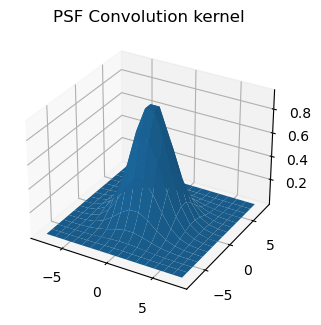

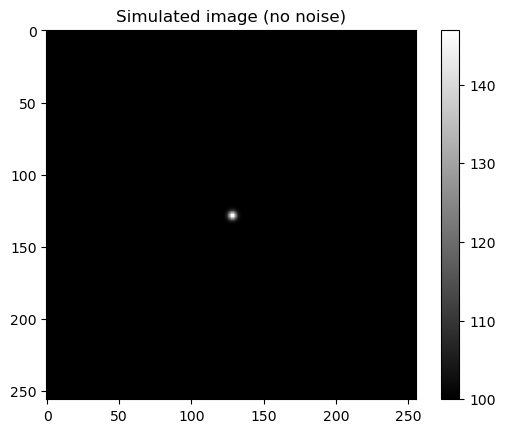

In [3]:
n = 256
im = np.zeros((n, n))
im[n//2, n//2] = 50

w_PSF = 4 # e-2 **radius** of PSF
Z = make_kernel(16, gauss2d, w_PSF)

im = sig.convolve2d(im, Z, mode='same')

im += 100

# im = np.random.poisson(im)
# im = np.random.normal(im, 5)

fig, ax = plt.subplots()
img = ax.imshow(im, 'gray')
cbar = fig.colorbar(img, ax=ax)
ax.set_title('Simulated image (no noise)')

## Wavelet transform

Text(0.5, 0.92, 'Largest wavelet scale = 12 px')

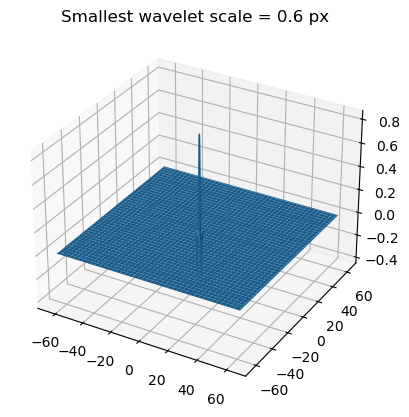

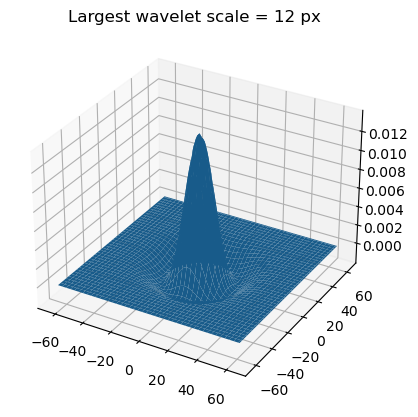

In [4]:
# Smallest and largest wavelet scales tested with kernel size = 128
fig, ax = plot_kernel(128, ricker2d, 0.6)
ax.set_title('Smallest wavelet scale = 0.6 px')
fig, ax = plot_kernel(128, ricker2d, 12)
ax.set_title('Largest wavelet scale = 12 px')

In [5]:
# Choice of scales to be tested
a1 = np.linspace(0.6, 2.5, 10)
a2 = np.linspace(3, 12, 10)
a_arr = np.concatenate((a1, a2))
a_arr

array([ 0.6       ,  0.81111111,  1.02222222,  1.23333333,  1.44444444,
        1.65555556,  1.86666667,  2.07777778,  2.28888889,  2.5       ,
        3.        ,  4.        ,  5.        ,  6.        ,  7.        ,
        8.        ,  9.        , 10.        , 11.        , 12.        ])

0.6
0.8111111111111111
1.0222222222222221
1.2333333333333334
1.4444444444444444
1.6555555555555554
1.8666666666666667
2.077777777777778
2.2888888888888888
2.5
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0


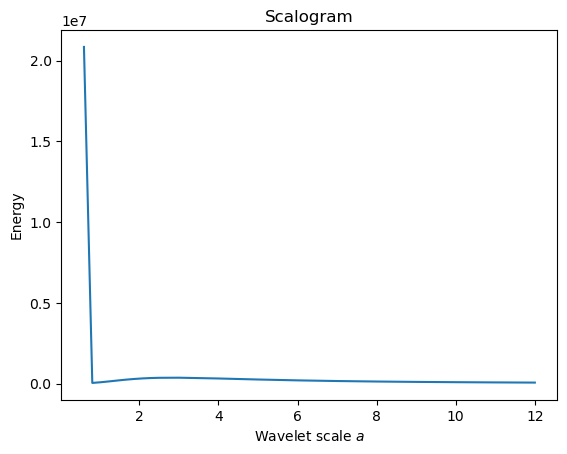

In [6]:
Es, wt_arr = scalogram(im, 128, a_arr, 50) # took 1 min to run

In [7]:
Es.size

20

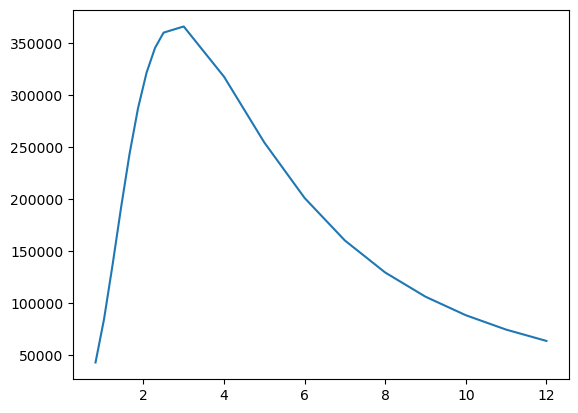

In [8]:
plt.plot(a_arr[1:], Es[1:])

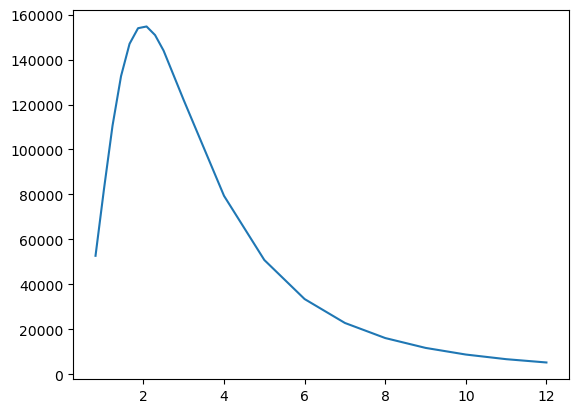

In [9]:
plt.plot(a_arr[1:], (1/a_arr[1:])*Es[1:])

In [10]:
max_arr = np.max(wt_arr, axis=(1,2))

[Text(0.5, 0, 'Wavelet scale $a$'),
 Text(0, 0.5, 'Maximum value'),
 Text(0.5, 1.0, 'Maximum value of wavelet transform at different scales')]

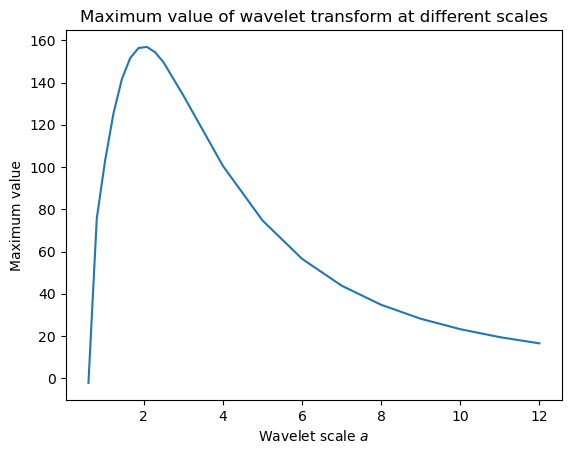

In [11]:
max_arr = np.max(wt_arr, axis=(1,2))

fig, ax = plt.subplots()
ax.plot(a_arr, max_arr)
ax.set(xlabel='Wavelet scale $a$', ylabel='Maximum value', title='Maximum value of wavelet transform at different scales')

Text(0.5, 1.0, 'Scale a = 12.0')

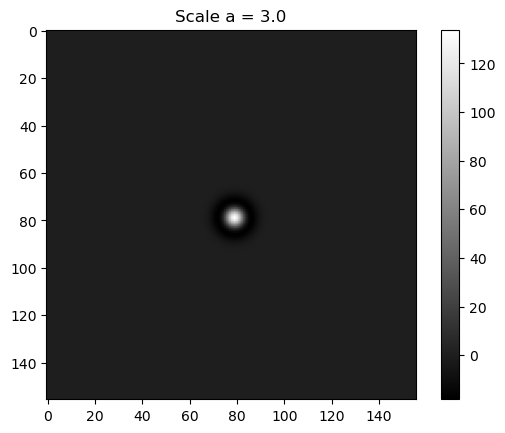

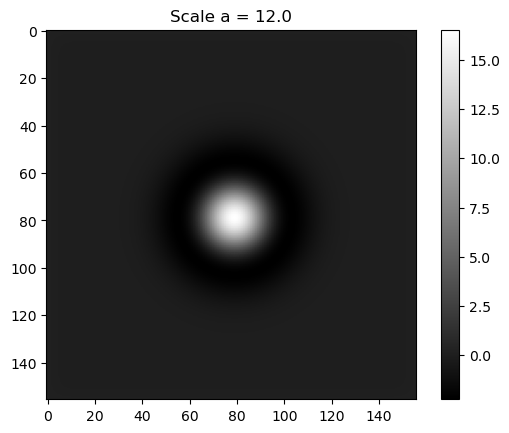

In [12]:
fig, ax, _ = show_im(wt_arr[10])
ax.set_title(f'Scale a = {a_arr[10]}')
fig, ax, _ = show_im(wt_arr[-1])
ax.set_title(f'Scale a = {a_arr[-1]}')

## Test larger scales

Text(0.5, 0.92, 'Largest wavelet scale = 20 px')

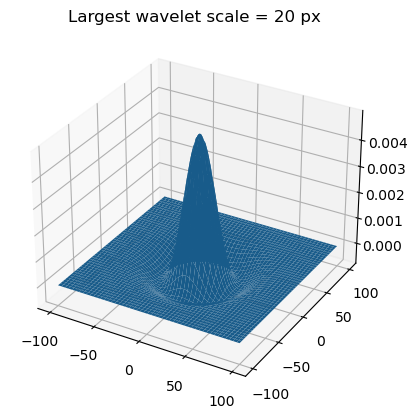

In [13]:
fig, ax = plot_kernel(200, ricker2d, 20)
ax.set_title('Largest wavelet scale = 20 px')

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x199f8fdd550>)

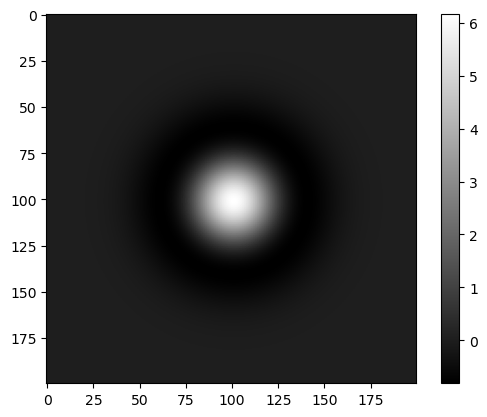

In [14]:
# took 16 sec
n = 400
im = np.zeros((n, n))
im[n//2, n//2] = 50
w_PSF = 4 # e-2 width of PSF
Z = make_kernel(16, gauss2d, w_PSF, show=False)
im = sig.convolve2d(im, Z, mode='same')
im += 100

wt = waveletTransform(im, 200, 20)
# show_im(wt)
show_im(wt[100:300, 100:300])

In [15]:
a_arr_2 = np.linspace(10, 20, 5)
a_arr_2

array([10. , 12.5, 15. , 17.5, 20. ])

10.0
12.5
15.0
17.5
20.0


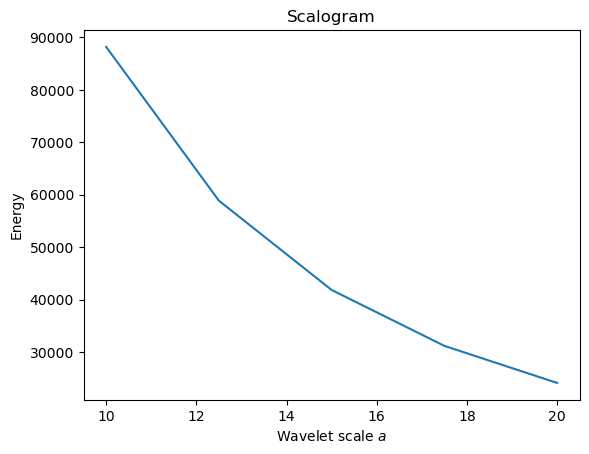

In [16]:
# took 1m45s
n = 400
im = np.zeros((n, n))
im[n//2, n//2] = 50
w_PSF = 4 # e-2 width of PSF
Z = make_kernel(16, gauss2d, w_PSF, show=False)
im = sig.convolve2d(im, Z, mode='same')
im += 100

a_arr_2 = np.linspace(10, 20, 5)

Es_2, wt_arr_2 = scalogram(im, 200, a_arr_2, 100)

In [17]:
print('hi')

hi


### Combine scalograms

[Text(0.5, 0, 'Scale $a$'),
 Text(0, 0.5, 'Energy'),
 Text(0.5, 1.0, 'Scalogram')]

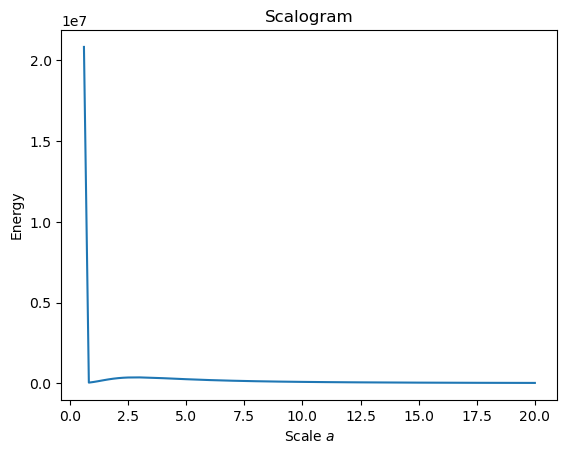

In [18]:
a1 = np.linspace(0.6, 2.5, 10)
a2 = np.linspace(3, 12, 10)
a3 = np.linspace(10, 20, 5)[1:]
a_all = np.concatenate((a1, a2, a3))

E_all = np.concatenate((Es, Es_2[1:]))

fig, ax = plt.subplots()
ax.plot(a_all, E_all)
ax.set(xlabel='Scale $a$', ylabel='Energy', title='Scalogram')

### Making sure i get same result with two different kernel sizes

In [19]:
# took 16 sec
n = 400
im = np.zeros((n, n))
im[n//2, n//2] = 50
w_PSF = 4 # e-2 width of PSF
Z = make_kernel(16, gauss2d, w_PSF, show=False)
im = sig.convolve2d(im, Z, mode='same')
im += 100

wt_1 = waveletTransform(im, 128, 12)
wt_2 = waveletTransform(im, 200, 12)

In [20]:
wt_1 = wt_1[100:300, 100:300]
wt_2 = wt_2[100:300, 100:300]

In [21]:
wt_1.max(), wt_2.max()

(16.525122840593536, 16.52158840153377)

In [22]:
np.sum(wt_1**2), np.sum(wt_2**2)

(63457.13242754308, 63456.6324311071)